### $\textbf{Python Notebook for Stochastic Simluation Algorithm
Trajectories of a Genetic Toggle Switch Architecture}$
$$\textbf{Seed Authors: Robert Egbert$^1$, Enoch Yeung$^2$}$$
$$\textbf{1 - Microbiome Sciences Group}$$ 
$$\textbf{2 - Data Science and Analytics Group}$$
$$\textbf{ Pacific Northwest National Laboratory}$$

$$\require{mhchem}$$     

### Import Packages

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Reaction dynamics for bistable toggle switch
\begin{equation}
\begin{aligned}[c]
\ce{p_{Lac} + LacI &<=>[k_b^L][k_r^L] p_{Lac}:LacI } \\
\ce{p_{Lac} &->[k_{TX}] {p_{Lac} + m_{TetR} }} \\ 
\ce{m_{TetR} &->[k_{TL}] {m_{TetR} + {TetR} }}\\ 
\ce{m_{TetR} &->[\delta_m] {\emptyset}}\\ 
\ce{TetR &->[\delta_p] {\emptyset}}
\end{aligned}[c]
\begin{aligned}[c]
\ce{p_{Tet} + TetR &<=>[k_b^T][k_r^T] p_{Tet}:TetR } \\ 
\ce{p_{Tet} &->[k_{TX}] {p_{Tet} + m_{LacI}}}\\
\ce{ m_{LacI} &->[k_{TL}] {m_{LacI} + {LacI}} }\\
\ce{m_{LacI} &->[\delta_m] {\emptyset}}\\
\ce{LacI &->[\delta_p] {\emptyset}}
\end{aligned}[c]
\end{equation}


### Initialize reaction network for toggle switch

In [25]:
# Initial molecule counts
pLac = 10
LacI = 0
pLacLacI = 0
mTetR = 0

pTet = 10
TetR = 0
pTetTetR = 0
mLacI = 0

init_counts = [pLac, LacI, pLacLacI, mTetR, pTet, TetR, pTetTetR, mLacI]

# Stoichiometry matrices for substrates and products
stoich_subst = [[-1 ,-1 , 0 , 0 , 0 , 0 , 0 , 0 ],
                [ 0 , 0 ,-1 , 0 , 0 , 0 , 0 , 0 ],
                [-1 , 0 , 0 , 0 , 0 , 0 , 0 , 0 ],
                [ 0 , 0 , 0 ,-1 , 0 , 0 , 0 , 0 ],
                [ 0 , 0 , 0 ,-1 , 0 , 0 , 0 , 0 ],
                [ 0 , 0 , 0 , 0 , 0 ,-1 , 0 , 0 ],
                [ 0 , 0 , 0 , 0 ,-1 ,-1 , 0 , 0 ],
                [ 0 , 0 , 0 , 0 , 0 , 0 ,-1 , 0 ],
                [ 0 , 0 , 0 , 0 ,-1 , 0 , 0 , 0 ],
                [ 0 , 0 , 0 , 0 , 0 , 0 , 0 ,-1 ],
                [ 0 , 0 , 0 , 0 , 0 , 0 , 0 ,-1 ],
                [ 0 ,-1 , 0 , 0 , 0 , 0 , 0 , 0 ],
               ]
stoich_prod  = [[0,0,1,0,0,0,0,0],
                [1,1,0,0,0,0,0,0],
                [1,0,0,1,0,0,0,0],
                [0,0,0,1,0,1,0,0],
                [0,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,1,0],
                [0,0,0,0,1,1,0,0],
                [0,0,0,0,1,0,0,1],
                [0,1,0,0,0,0,0,1],
                [0,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0,0],
               ]
stoich_mtx = np.array(stoich_subst) + np.array(stoich_prod)

num_rxn, num_spec = stoich_mtx.shape

### Identify reaction rates and run single SSA trajectory ($\tau$ leaping)

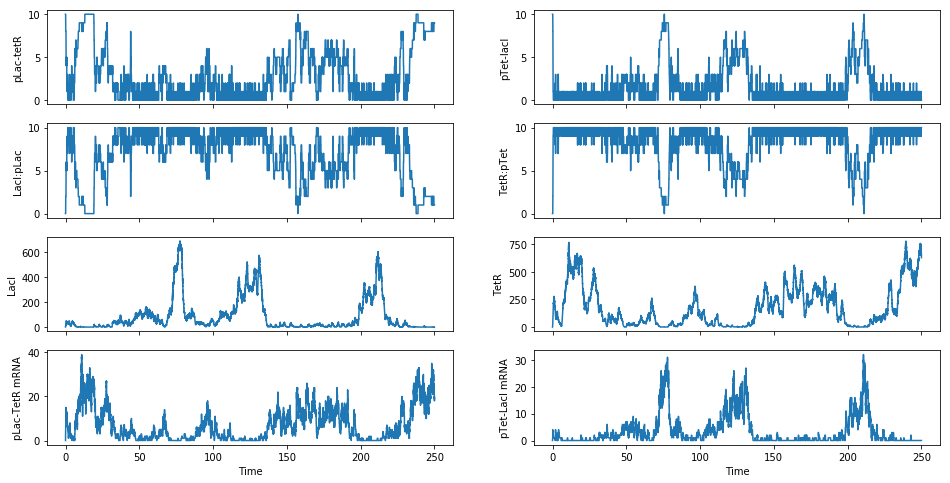

In [42]:
# Reaction constants
k_bL = 0.1
k_rL = 0.5
k_bT = 0.1
k_rT = 0.5
k_TX = 5.0
k_TL = 50.0
d_m = 2.0
d_p = 2.0

rxn_rates = [k_bL, k_rL, k_bT, k_rT, k_TX, k_TL, d_m, d_p]

t_max = 250
r_max = 1000000

tau_steps,rxn_fired,reactant_traj = SSA(init_counts,rxn_rates,stoich_mtx,t_max,r_max)

pltSSAtraj(tau_steps,reactant_traj)

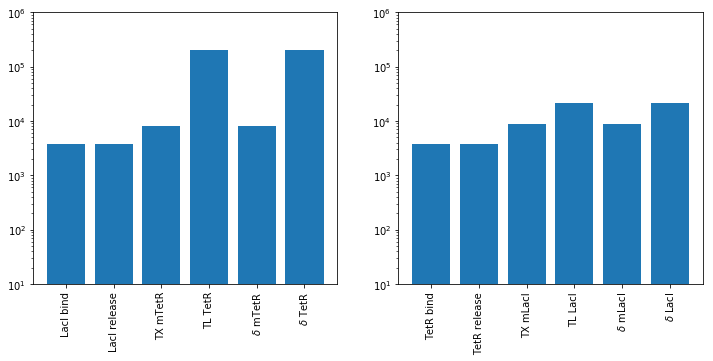

In [16]:
pltRxnDist(rxn_fired)

In [43]:
traj = 0
cols = ['pLac-tetR','LacI','LacI:pLac','pLac-TetR mRNA','pTet-lacI','TetR','TetR:pTet','pTet-LacI mRNA']
fullCols = cols[:]
fullCols[:0] = ['Time']
while traj < 10000:

    tau_steps,rxn_fired,reactant_traj = SSA(init_counts,rxn_rates,stoich_mtx,t_max,r_max)
    df = pd.DataFrame(reactant_traj,columns=cols)
    df['Time'] = tau_steps
    traj +=1
    df[fullCols].to_csv('Trajectories/Toggle_traj{:05d}.csv'.format(traj))

In [27]:
def pltSSAtraj(tau_steps,reactant_traj):
    spec_names = ['pLac-tetR','LacI','LacI:pLac','pLac-TetR mRNA','pTet-lacI','TetR','TetR:pTet','pTet-LacI mRNA']
    fig, ax = plt.subplots(4,2,figsize=(16,8),sharex=True)
    for c in [0,1]:
        for n, r in enumerate([0,2,1,3]):
            ax[n,c].plot(tau_steps,reactant_traj[:,4*c+r])
            ax[n,c].set_ylabel(spec_names[4*c+r])
    #        ax[n,c].set_xlim([0,100])
    [ax[3,c].set_xlabel('Time') for c in [0,1]];
    [ax[r,c].set_ylim([-0.5,10.5]) for r in [0,1] for c in [0,1]];

def pltRxnDist(rxn_fired):

    rxn_names = ['LacI bind','LacI release','TX mTetR','TL TetR',r'$\delta$ mTetR',r'$\delta$ TetR',
             'TetR bind','TetR release','TX mLacI','TL LacI',r'$\delta$ mLacI',r'$\delta$ LacI']
    rxn = np.array(rxn_fired)
    rxn_f = rxn[rxn > -1]
    rxnHist = np.histogram(rxn_f[rxn_f > -1],bins=12)[0]

    fig, ax = plt.subplots(1,2,figsize=(12,5))
    ax[0].bar(range(6),rxnHist[:6])
    ax[0].set_xticks(range(6))
    ax[0].set_xticklabels(rxn_names[:6],rotation=90)
    ax[1].bar(range(6),rxnHist[6:])
    ax[1].set_xticks(range(6))
    ax[1].set_xticklabels(rxn_names[6:],rotation=90)
    for a in ax:
        a.set_ylim(bottom=1e1,top=10**np.ceil(np.log10(np.max(rxnHist))))
        a.set_yscale('log')

In [17]:
def updatePropensities(rxn_rates, mol_counts):
    # unpack reaction rates
    k_bL, k_rL, k_bT, k_rT, k_TX, k_TL, d_m, d_p = rxn_rates
    # unpack reactants
    pLac, LacI, pLacLacI, mTetR, pTet, TetR, pTetTetR, mLacI = mol_counts
    
    a1f = k_bL*pLac*LacI
    a1r = k_rL*pLacLacI
    a2  = k_TX*pLac
    a3  = k_TL*mTetR
    a4  = d_m*mTetR
    a5  = d_p*TetR
    a6f = k_bT*pTet*TetR
    a6r = k_rT*pTetTetR
    a7  = k_TX*pTet
    a8  = k_TL*mLacI
    a9  = d_m*mLacI
    a10 = d_p*LacI
    
    return np.array([a1f, a1r, a2, a3, a4, a5, a6f, a6r, a7, a8, a9, a10])

def NextRxnTau(rates):
    k_tot = np.sum(rates)
    rNum = np.random.random()*k_tot
    mu = 0
    s = rates[0]
    while rNum >= s:
        mu += 1
        s = s + rates[mu]
    tau = 1/k_tot * np.log(1/np.random.random())
    return mu, tau

def SSA(init, rates, stoich_mtx, t_max, r_max):

    t = 0 # time elapsed
    r = 0 # number of occured reactions
    t_vals = [t] # Initialize storage of times
    rxn_list = [-1]
    mol_list = [init] # Initialize storage of molecule counts

    # Initialize molecule counts
    mols = init
    # Generate random seed for trajectory
    np.random.seed()

    # Loop through reaction firing until a limit is met
    while t < t_max and r < r_max:
        # Update propensities based on reactant counts and reaction rates
        prop = updatePropensities(rxn_rates,mols)
        # Use tau leaping to identify next reaction
        nextRxn, tau = NextRxnTau(prop)
        # Update values based on stoichometry matrix
#        print "Reaction #{}".format(nextRxn)
        mols = mols + stoich_mtx[nextRxn].transpose()
        mols[mols < 0] = 0
        # Update time and reactant counts & store values
        t = t + tau
        t_vals.append(t)
        r += 1
        rxn_list.append(nextRxn)
        mol_list.append(list(mols))
        
    return t_vals, rxn_list, np.array(mol_list)